## Imports

In [1]:
import numpy as np
import pennylane as qml
import matplotlib.pyplot as plt
import torch

## Loss function

In [26]:
# MMR method implemented
def newton(loss_fn, x0, lr=0.1, iteration=100, convergence=1e-6, verbose=False):
    x = x0
    losses = []
    for i in range(iteration):
        
        loss = loss_fn(x)
        # retain graph to calculate hessian
        loss.backward(retain_graph=True)
        
        # Newton step
        hessian = torch.autograd.functional.hessian(loss_fn, x)
        hessian_inv = torch.inverse(hessian)
        grad = torch.autograd.grad(loss, x)
        newton_step = -torch.matmul(hessian_inv, grad[0])
        
        # Line search
        alpha = 1
        while loss_fn(x + alpha*newton_step) > loss_fn(x) + lr*alpha*torch.matmul(grad[0], newton_step):
            alpha *= 0.5
            
        x = x + alpha*newton_step
        
        if torch.norm(alpha*newton_step) < convergence:
            break
            
        if i % 10 == 0 and verbose:
            print(f"Iteration {i}: {loss.item()}")   
            
        losses.append(loss.item())
            
    return x, losses

def mmr_newton(data, k, convergence=1e-6, verbose=False):
    x_data = torch.tensor(data[0])
    y_data = torch.tensor(data[1])
    
    k_evaluated_at_data_points = torch.zeros((len(x_data), len(x_data)))
    for i in range(len(x_data)):
        for j in range(len(x_data)):
            k_evaluated_at_data_points[i, j] = k(x_data[i], y_data[j])
    
    def trial_function_evaluated_at_data_points(a, b):
        result = torch.zeros_like(a)
        result += b
        for i in range(len(a)):
            result += a[i]*k_evaluated_at_data_points[:, i]
        return result
    
    def trial_function(x, a, b):
        result=b
        for i in range(len(a)):
            result += a[i]*k(x, y_data[i])
        return result
    
    def loss_function(alphas):
        b = alphas[0]
        a = alphas[1:]
        y_trial = trial_function_evaluated_at_data_points(a, b)
        result = torch.sum((y_data-y_trial)**2)
        return result
    
    x0 = torch.tensor([torch.sum(x_data)/len(x_data), *torch.zeros_like(y_data)], requires_grad=True)
    
    minimization, losses = newton(loss_function, x0, iteration=100, convergence=convergence, verbose=verbose)
    minimization = minimization.clone().detach().numpy()
    
    b = minimization[0]
    a = minimization[1:]
    
    def optimized_trial_function(x):
        return trial_function(x, a, b)
    
    return optimized_trial_function, losses


def mmr_DE_newton(DE, data, x0, f0, k, verbose=False):
    x_data = torch.tensor(data[0])
    y_data = torch.tensor(data[1])
    
    k_at_initial_condition = torch.zeros(len(x_data))
    for i in range(len(x_data)):
        k_at_initial_condition[i] = k(x0, y_data[i])

    def f0_trial(a, b):
        result = 0
        result += b
        for i in range(len(a)): 
            result += a[i]*k_at_initial_condition[i]
        return result

    k_evaluated_at_data_points = torch.zeros((len(x_data), len(x_data)))
    dk_dx_evaluated_at_data_points = torch.zeros((len(x_data), len(x_data)))
    for i in range(len(x_data)):
        for j in range(len(x_data)):
            
            x_i = x_data[i].clone().detach().requires_grad_(True)
            out = k(x_i, y_data[j])
            out.backward()

            dk_dx_evaluated_at_data_points[i, j] = x_i.grad
            k_evaluated_at_data_points[i, j] = out.clone().detach()


    def trial_function_evaluated_at_data_points(a, b):
        result = torch.zeros_like(a)
        result += b
        for i in range(len(a)): 
            result += a[i]*k_evaluated_at_data_points[:, i]
        return result
    
    def dx_trial_function_evaluated_at_data_points(a, b):
        result = torch.zeros_like(a)
        for i in range(len(a)): 
            result += a[i]*dk_dx_evaluated_at_data_points[:, i]
        return result
    
    def trial_function(x, a, b):
        result=b
        for i in range(len(a)):
            result += a[i]*k(x, y_data[i])
        return result
    
    def loss_function(alphas):
        b = alphas[0]
        a = alphas[1:]
        result = (f0-f0_trial(a, b))**2
        f_trial = trial_function_evaluated_at_data_points(a, b)
        df_dx_trial = dx_trial_function_evaluated_at_data_points(a, b)
        for i in range(len(x_data)):
            result += DE(x_data[i], f_trial[i], df_dx_trial[i])**2
        return result
    
    x0 = torch.tensor([torch.sum(x_data)/len(x_data), *torch.zeros_like(y_data)], requires_grad=True)

    minimization, losses = newton(loss_function, x0, verbose=verbose)
    minimization = minimization.clone().detach().numpy()
    
    b = minimization[0]
    a = minimization[1:]
    
    def optimized_trial_function(x):
        return trial_function(x, a, b)
    
    return optimized_trial_function

## Kernel

### Kernel library

In [3]:
from pennylane.templates import BasicEntanglerLayers, AngleEmbedding, StronglyEntanglingLayers

#classical kernel, k(x, y) = exp(-(x-y)**2/(2*sigma**2))
def K_classical(sigma):
    def k(x, y):
        return torch.exp(-(x-y)**2/(2*sigma**2))
    return k

def make_kernel(U, N):
    def k(x, y):
        @qml.qnode(qml.device('default.qubit', wires=N), interface="torch")
        def kernel_circuit(x, y):
            U(y)
            qml.adjoint(U)(x)
            return qml.probs(wires=range(N))
        
        return kernel_circuit(x, y)[0]
    
    return k

#quantum kernel with a single Rx gate on every qubit as a feature map
def K_simple_RX(N):
    def U(x):
        for n in range(N):
            qml.RX(x, wires=n)

    return make_kernel(U, N)

def K_layered(N, n_layers):
    def phi(x, q):
        return q * x / 2

    def U(x):
        
        def U_x():
            for n in range(N):
                qml.RX(phi(x, n), wires=n)
                
        for layer in range(n_layers):
            for wire in range(N):
                qml.RY(phi(x, wire), wires=wire)
            
            U_x()
            
            # If last layer, no entangler
            if layer == n_layers-1:
                continue
                
            # CNOT entangler (alternate for each layer)
            if layer % 2 == 0:
                for wire in range(0, N-1, 2):
                    qml.CNOT(wires=[wire, wire+1])
            else:
                for wire in range(1, N-1, 2):
                    qml.CNOT(wires=[wire, wire+1])
                
                qml.CNOT(wires=[N-1, 0])
            
        
    return make_kernel(U, N)

### Visualize Kernel

In [4]:
def kernel_subplot(ax, k, N, grid_res=15):
    xs = np.linspace(0, 2*np.pi, grid_res)
    KK = np.array([[k(x, y) for x in xs] for y in xs])

    ax.set_title(rf"$\kappa(x, y)$ for $N={N}$ qubits")
    ax.imshow(KK, extent=(0, 2*np.pi, 0, 2*np.pi))
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_xticks([0, np.pi, 2*np.pi], ["0", r"$\pi$", r"$2\pi$"])
    ax.set_yticks([0, np.pi, 2*np.pi], ["0", r"$\pi$", r"$2\pi$"])
    
def loss_plot(lossesArray, labels=None):
    for i, losses in enumerate(lossesArray):
        label = labels[i] if labels is not None else f"loss {i}"
        plt.plot(losses, label=label)
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.yscale("log")
    plt.legend()
    plt.show()

def compare_plot(f_opt, f_sol, data, xs):
    x = data[0]
    y = data[1]
    plt.plot(x, y, "x", label="data", color="black", alpha=0.5)
    plt.plot(xs, [f_sol(x) for x in xs], label="analytic")
    plt.plot(xs, [f_opt(x) for x in xs], label="opt", linestyle="--")
    plt.ylabel("f(x)")
    plt.xlabel("x")
    plt.legend()
    plt.show()

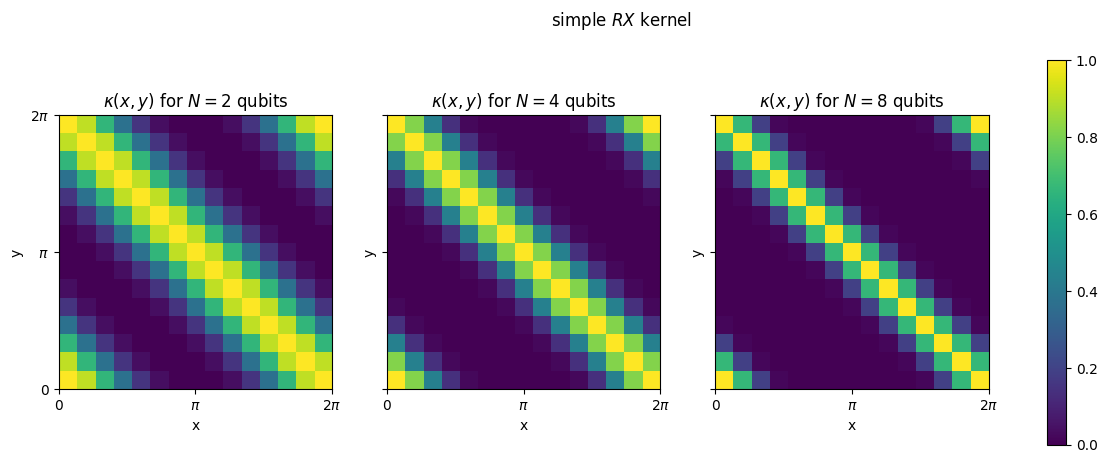

In [5]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
fig.suptitle(r"simple $RX$ kernel")
k = K_simple_RX(2)
kernel_subplot(axs[0], k, 2)
k = K_simple_RX(4)
kernel_subplot(axs[1], k, 4)
k = K_simple_RX(8)
kernel_subplot(axs[2], k, 8)
# colorbar
fig.colorbar(axs[2].images[0], ax=axs, orientation="vertical")
plt.show()

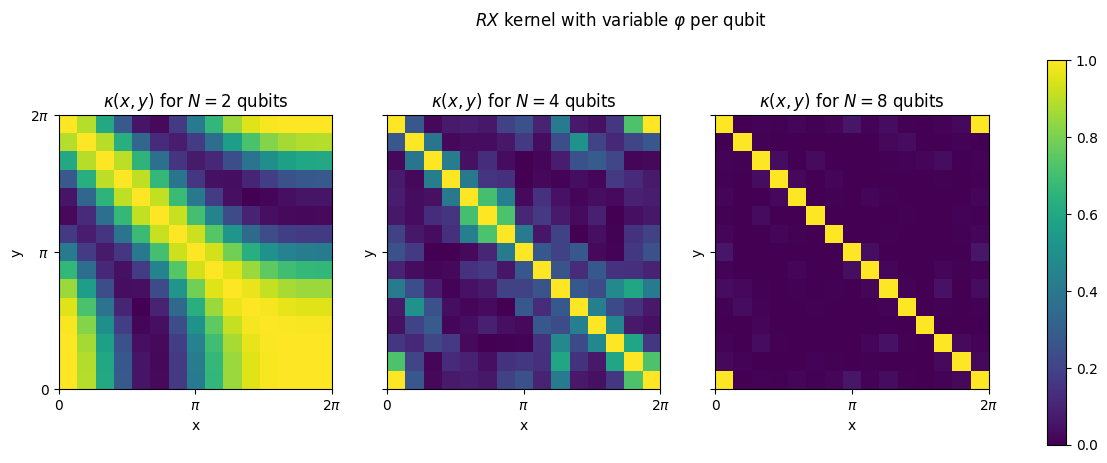

In [6]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
fig.suptitle(r"$RX$ kernel with variable $\varphi$ per qubit")
k = K_layered(2, n_layers=2)
kernel_subplot(axs[0], k, 2)
k = K_layered(4, n_layers=2)
kernel_subplot(axs[1], k, 4)
k = K_layered(8, n_layers=2)
kernel_subplot(axs[2], k, 8)
# colorbar
fig.colorbar(axs[2].images[0], ax=axs, orientation="vertical")
plt.show()

## Results

### $f(x) = x^2$

In [7]:
x = np.linspace(0, 0.1, 51)
y = x**2
data = np.array([x, y])

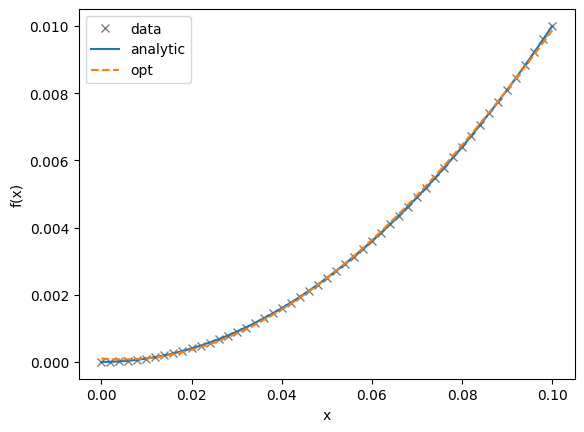

In [8]:
k = K_classical(0.14)
f,_ = mmr_newton(data, k)

compare_plot(f, lambda x: x**2, data, xs=np.linspace(0, 0.1, 100))

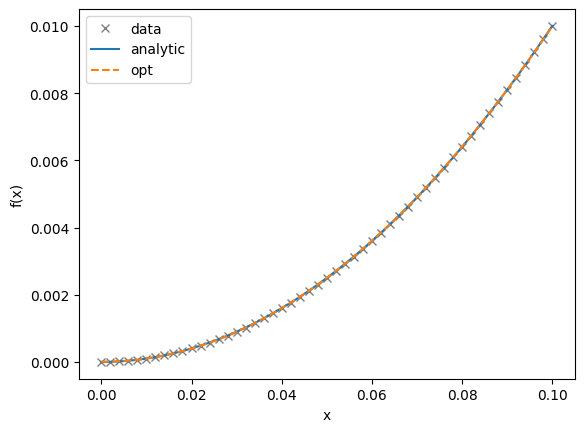

In [9]:
k = K_simple_RX(8)
f,_ = mmr_newton(data, k)

compare_plot(f, lambda x: x**2, data, xs=np.linspace(0, 0.1, 100))

### $f(x) = \exp(x)$

In [10]:
x = np.linspace(0, 5.0, 51)
y = np.exp(x)
data = np.array([x, y])

In [11]:
k = K_classical(0.14)
try:
    f,_ = mmr_newton(data, k)
    plt.plot(x, y, label="trial")
    plt.plot(x, np.array([f(x) for x in x]), label="original")

except RuntimeError as e:
    print(e)

linalg.inv: The diagonal element 22 is zero, the inversion could not be completed because the input matrix is singular.


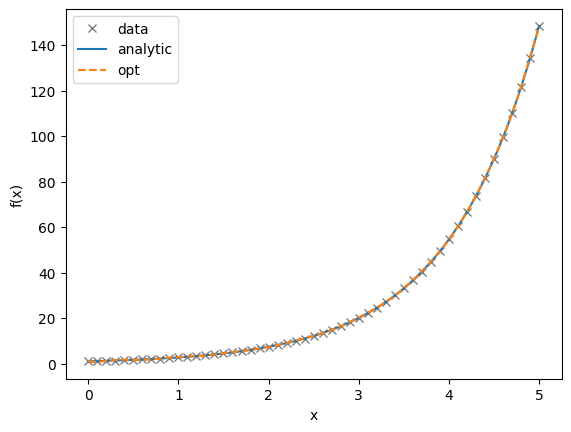

In [12]:
k = K_simple_RX(8)
f, lossesQK = mmr_newton(data, k)

compare_plot(f, np.exp, data, xs=np.linspace(0, 5, 100))

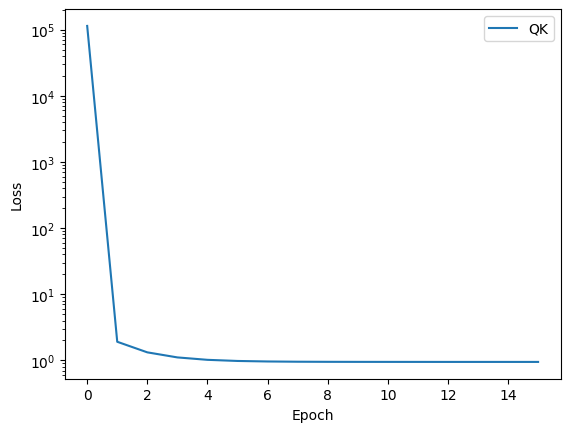

In [13]:
loss_plot([lossesQK], labels=["QK"])

### $\frac{df}{dx} = -\lambda \kappa f - \lambda \exp(\lambda \kappa x)\sin(\lambda x)$

with Solution: $f_{sol}(x) = -\lambda \exp(-\lambda \kappa x)\cos(\lambda x)$

In [14]:
def df_dx(x, f, l, k):
    return -l * k * f -l * np.exp(-l * k * x) * np.sin(l * x)

def f_sol(x, l, k):
    return np.exp(-l*k*x)*np.cos(l*x)

llambda = 20
kk = 0.1

x = np.linspace(0, 1, 21)
y = f_sol(x, llambda, kk)
data = np.array([x, y])

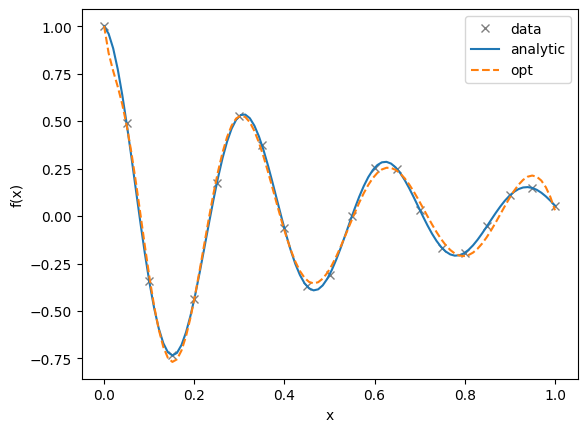

In [15]:
k = K_classical(0.2)
f, lossesRBF = mmr_newton(data, k)
    
compare_plot(f, lambda x: f_sol(x, llambda, kk), data, xs=np.linspace(0, 1, 100))

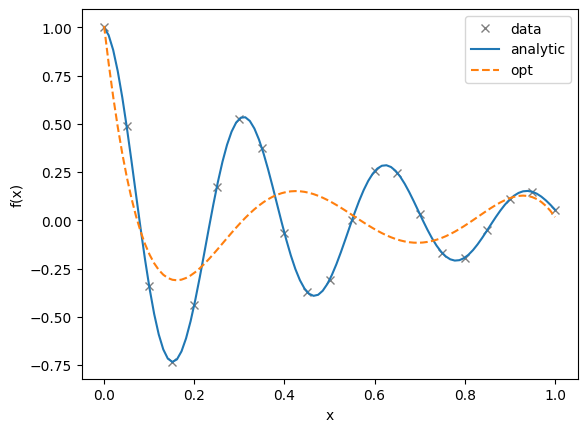

In [16]:
k = K_simple_RX(8)
f, lossesQK_simple = mmr_newton(data, k, convergence=1e-6)

compare_plot(f, lambda x: f_sol(x, llambda, kk), data, xs=np.linspace(0, 1, 100))

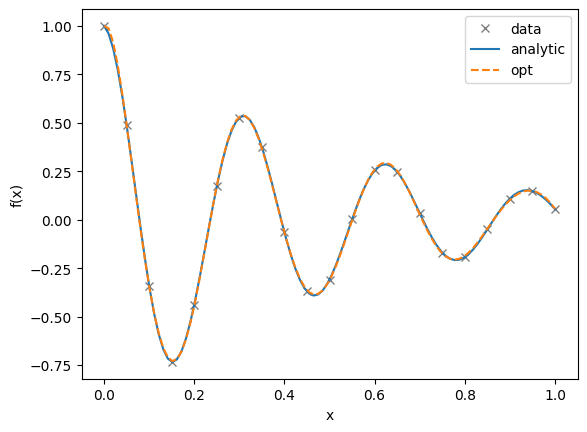

In [17]:
k = K_layered(8, n_layers=2)
f, lossesQK = mmr_newton(data, k, convergence=1e-6)

compare_plot(f, lambda x: f_sol(x, llambda, kk), data, xs=np.linspace(0, 1, 100))

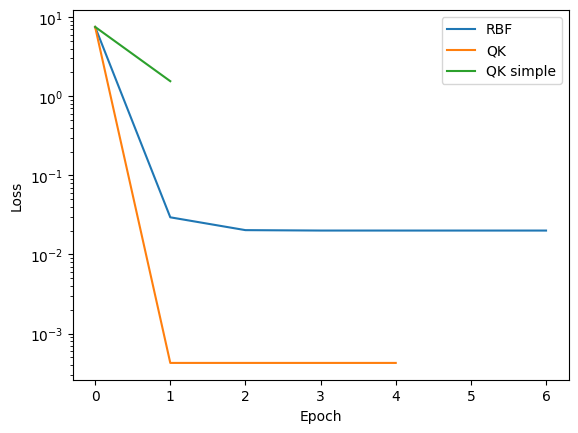

In [18]:
loss_plot([lossesRBF, lossesQK, lossesQK_simple], labels=["RBF", "QK", "QK simple"])

In [19]:
def make_DE(llambda, kk):
    def DE(x, f, dfdx):
        return dfdx - df_dx(x, f, llambda, kk)
    
    def f_sol(x):
        return np.exp(-llambda * kk * x) * np.cos(llambda * x)
    
    return DE, f_sol

In [30]:
x = np.linspace(0, 1, 21)
y = x

DE, sol = make_DE(20, 0.1)
k = K_layered(8, n_layers=5)
f = mmr_DE_newton(DE, [x, y], 0, 1, k, verbose=True)

Iteration 0: 1030.3576076078064


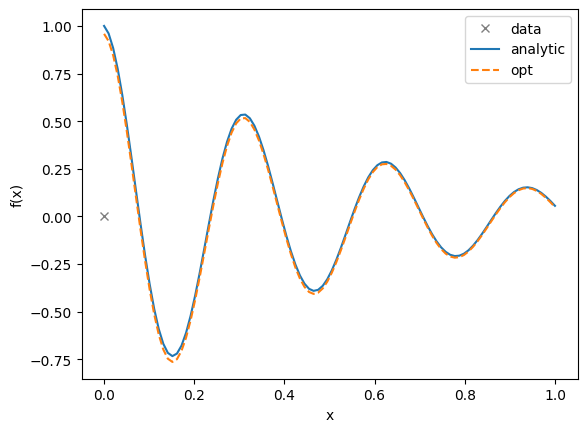

In [31]:
compare_plot(f, sol, [0, 0], xs=np.linspace(0, 1, 100))